In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# read csvs
df_features = pd.read_csv('dataset/features.csv')
df_stores = pd.read_csv('dataset/stores.csv')
df_train = pd.read_csv('dataset/train.csv')

In [3]:
# adjust display options
pd.options.display.max_rows = 555
pd.set_option('display.max_columns', None)

## Merge Datasets

In [4]:
### merge datasets

# add features to train dataset
df = df_train.merge(df_features, on= ['Store','Date', 'IsHoliday'])

# add store details to train dataset
df = df.merge(df_stores, on='Store')

In [5]:
### rename columns to lower case
df.columns = df.columns.str.lower()

In [6]:
# split date column into relevant time features
df.date=pd.to_datetime(df.date)

df['weekday'] = df.date.dt.weekday
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year

# Drop date column
df = df.drop(columns=['date'])

In [7]:
# save a copy of df before cleaning
df_raw = df

## Establish Key Information

In [8]:
target = 'weekly_sales'
features = [i for i in df.columns if i not in [target]]

## 2. EDA - Exploratory Data Analysis 

Let's understand the distribution of numerical variables

In [9]:
df_eda = df_raw[['temperature', 'fuel_price', 'cpi', 'unemployment', 'size']]

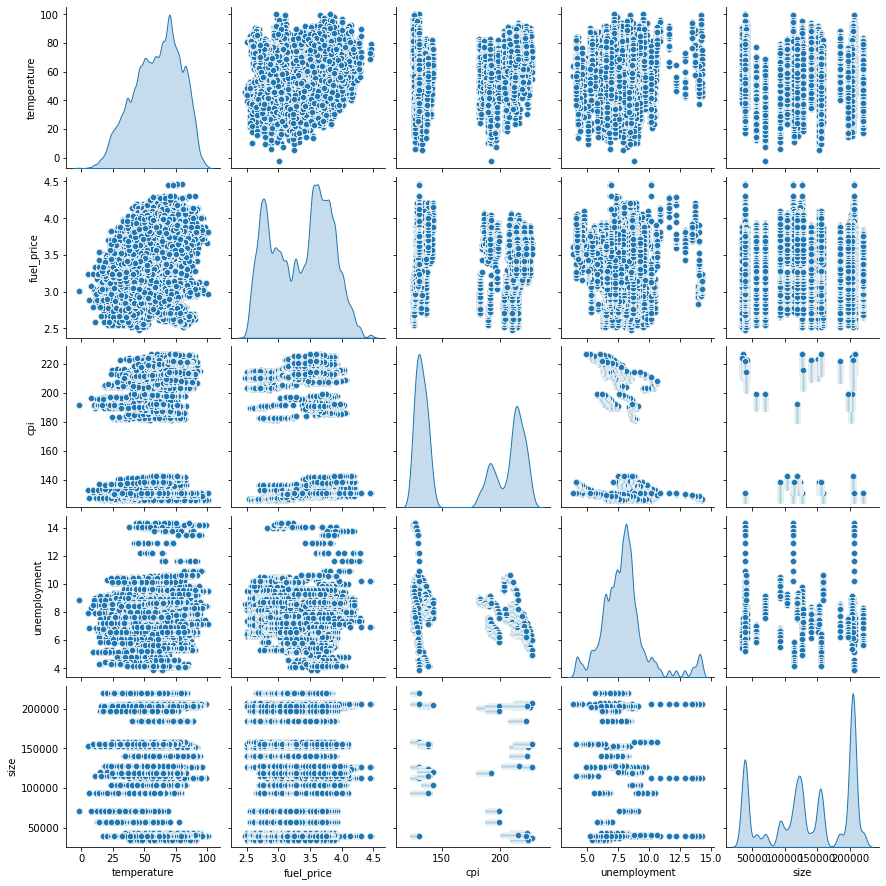

In [10]:
sns.pairplot(data=df_eda, diag_kind='kde')

**Summary**
- Numerical variables cpi and size are skewed
- Temperature and unemployment somewhat normally distributed
- No noticeable correlation between variables

In [11]:
df.describe()

,store,dept,weekly_sales,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,size,weekday,month,year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739,4.0,6.449510,2010.968591
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328,0.0,3.243217,0.796876
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000,4.0,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000,4.0,4.000000,2010.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000,4.0,6.000000,2011.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000,4.0,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,4.0,12.000000,2012.000000


<Figure size 1008x1008 with 0 Axes>

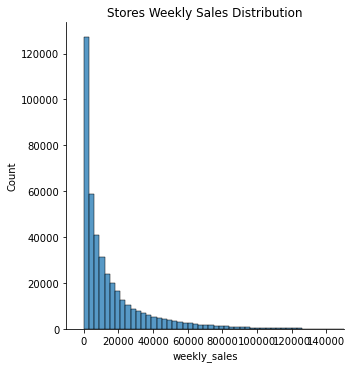

In [12]:
# Visualise our target distribution - weekly sales
plt.figure(figsize=[14,14])
custom_bins = [i*3000 for i in range(60)]
sns.displot(df['weekly_sales'], bins = custom_bins)
plt.title('Stores Weekly Sales Distribution')
plt.xlim(-10000, 150000)
plt.show()

**Takeaway**: Target variable's destribution heavily left skewed.

In [13]:
# display count of unique values in each column
uniq_cnt = df.nunique().sort_values()
df.nunique().sort_values()

weekday              1
isholiday            2
year                 3
type                 3
month               12
size                40
store               45
dept                81
unemployment       349
fuel_price         892
markdown2         1499
markdown3         1662
markdown4         1944
cpi               2145
markdown1         2277
markdown5         2293
temperature       3528
weekly_sales    359464
dtype: int64

### Understanding dataset's categorical variables

<AxesSubplot:title={'center':'Distribution of categorical variable: isholiday'}, xlabel='isholiday', ylabel='count'>

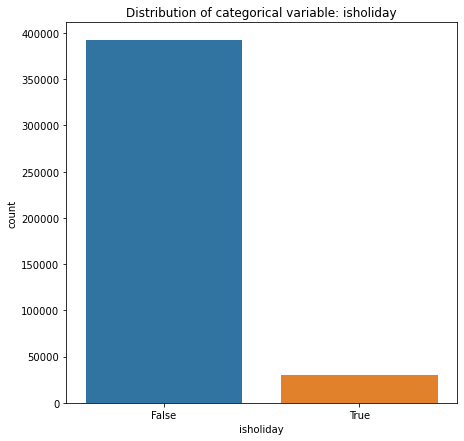

In [14]:
var = 'isholiday'
plt.figure(figsize=(7,7))
plt.title('Distribution of categorical variable: ' + var)
sns.countplot(x=df[var])

**Takeaway**: Expected distribution for nature of feature.

<AxesSubplot:title={'center':'Distribution of categorical variable: type'}, xlabel='type', ylabel='count'>

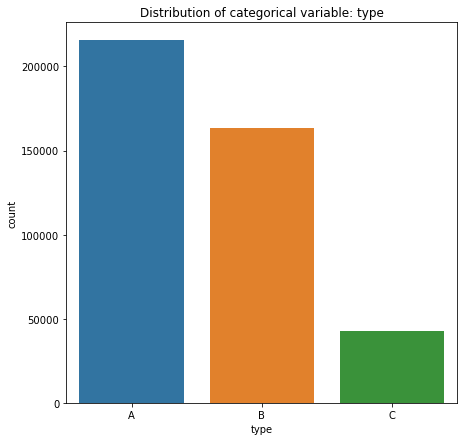

In [15]:
var = 'type'
plt.figure(figsize=(7,7))
plt.title('Distribution of categorical variable: ' + var)
sns.countplot(x=df[var])

**Takeaway**: Imbalanced distribution of store types.

<AxesSubplot:title={'center':'Distribution of categorical variable: month'}, xlabel='month', ylabel='count'>

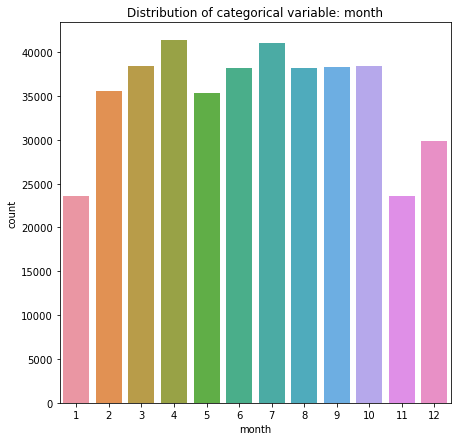

In [16]:
var = 'month'
plt.figure(figsize=(7,7))
plt.title('Distribution of categorical variable: ' + var)
sns.countplot(x=df[var])

**Takeaway**: Somewhat unexpected distribution for month variable.

<AxesSubplot:title={'center':'Distribution of categorical variable: store'}, xlabel='store', ylabel='count'>

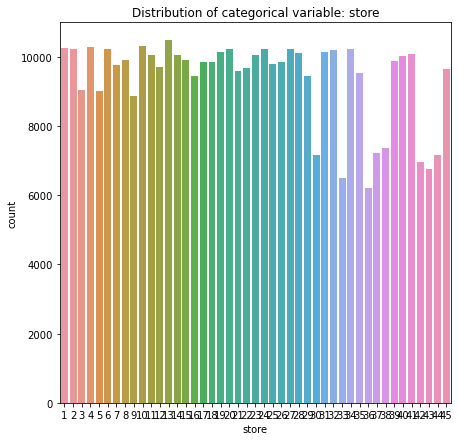

In [17]:
var = 'store'
plt.figure(figsize=(7,7))
plt.title('Distribution of categorical variable: ' + var)
sns.countplot(x=df[var])

**Takeaway**: Certain stores have lower recorded observations

<AxesSubplot:title={'center':'Distribution of categorical variable: dept'}, xlabel='dept', ylabel='count'>

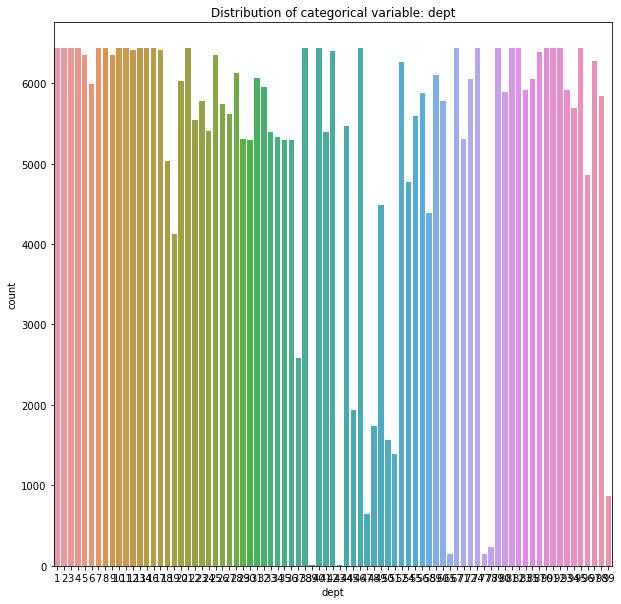

In [18]:
var = 'dept'
plt.figure(figsize=(10,10))
plt.title('Distribution of categorical variable: ' + var)
sns.countplot(x=df[var])

**Takeaway**: Certain departments have very few data points, which can cause bias due to high variability.

### Understanding dataset's numerical variables

Text(0.5, 1.0, 'Distribution of numerical variable: unemployment')

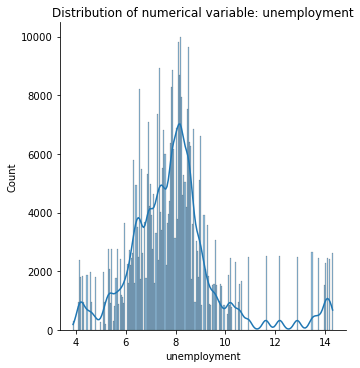

In [19]:
### Numerical variable: unemployment
var = 'unemployment'
sns.displot(x=df[var], height = 5, kde=True)
plt.title('Distribution of numerical variable: ' + var)

Text(0.5, 1.0, 'Boxplot of: unemployment')

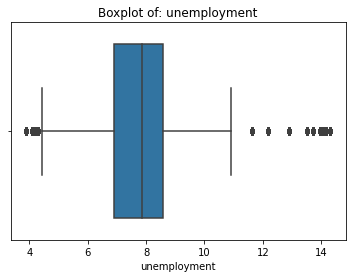

In [20]:
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

**Takeaway**: Unemployment variable is somewhat normal distributed with anomalies.

Text(0.5, 1.0, 'Distribution of numerical variable: fuel_price')

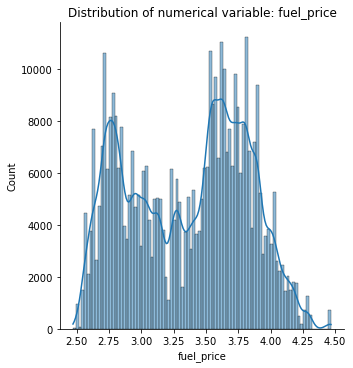

In [21]:
### Numerical variable Fuel Price
var = 'fuel_price'
sns.displot(x=df[var], height = 5, kde=True)
plt.title('Distribution of numerical variable: ' + var)

Text(0.5, 1.0, 'Boxplot of: fuel_price')

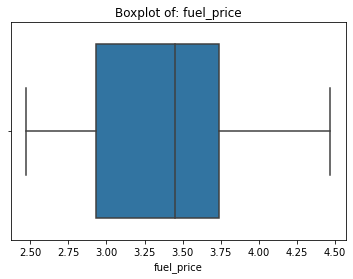

In [22]:
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

**Takeaway**: Nothing inherently significant

Text(0.5, 1.0, 'Distribution of numerical variable: cpi')

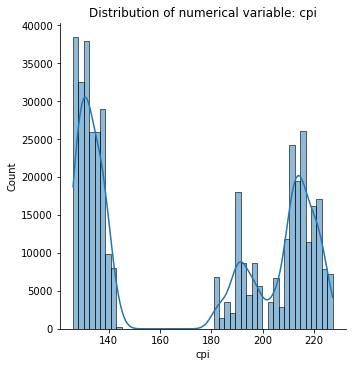

In [23]:
### Numerical variable CPI
var = 'cpi'
sns.displot(x=df[var], height = 5, kde=True)
plt.title('Distribution of numerical variable: ' + var)

Text(0.5, 1.0, 'Boxplot of: cpi')

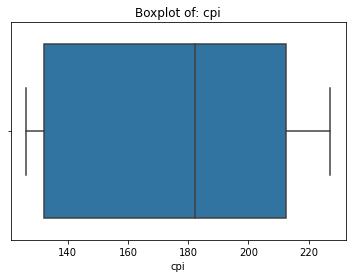

In [24]:
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

Text(0.5, 1.0, 'Distribution of numerical variable: temperature')

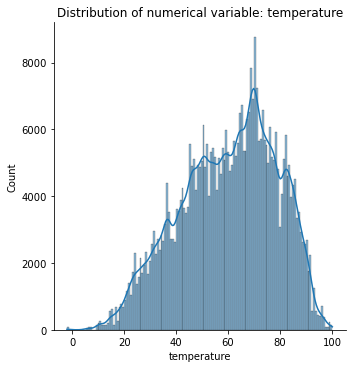

In [25]:
### Numerical variable CPI
var = 'temperature'
sns.displot(x=df[var], height = 5, kde=True)
plt.title('Distribution of numerical variable: ' + var)

Text(0.5, 1.0, 'Boxplot of: temperature')

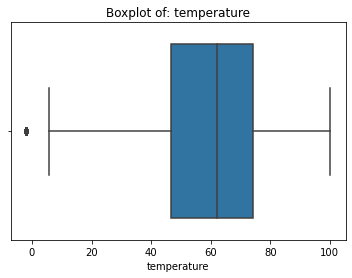

In [26]:
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

#### Pairplot to understand information between all features

In [27]:
# sns.pairplot(df)

## 3. Data Preprocessing

In [28]:
# check for the presence of null values
df.isnull().sum()

store                0
dept                 0
weekly_sales         0
isholiday            0
temperature          0
fuel_price           0
markdown1       270889
markdown2       310322
markdown3       284479
markdown4       286603
markdown5       270138
cpi                  0
unemployment         0
type                 0
size                 0
weekday              0
month                0
year                 0
dtype: int64

'markdown' columns expected to have null values as stores do not always have discounts/promotions

In [29]:
### Fill null with 0 to represent no discounts
df = df.fillna(0)

In [30]:
### Drop duplicates

counter = 0
rs,cs = df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mResult:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mResult:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Result: The dataset doesn't have any duplicates


### Feature Engineering/Transformation

In [31]:
# create column to reflect if any promotion exists
df['have_promotion'] = 1

for i in range(len(df)):
    if df.loc[i]['markdown1'] == 0:
        if df.loc[i]['markdown2'] == 0:
            if df.loc[i]['markdown3'] == 0:
                if df.loc[i]['markdown4'] == 0:
                    if df.loc[i]['markdown5'] == 0:
                        df.at[df.index[i], 'have_promotion'] = 0
                        
# # similar speed as above
# col_lst = ['markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5']
# df['have_promotion'] = df[col_lst].all(1).astype(int)

In [32]:
# one-hot encoding
df['isholiday'] = df['isholiday'].map({True:1, False:0})

In [33]:
# Creating dummies for categorical variables
df = pd.get_dummies(df, columns=['store', 'dept', 'type','year','month'],  drop_first=True)

In [34]:
df.head()

,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,size,weekday,have_promotion,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17,store_18,store_19,store_20,store_21,store_22,store_23,store_24,store_25,store_26,store_27,store_28,store_29,store_30,store_31,store_32,store_33,store_34,store_35,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,dept_11,dept_12,dept_13,dept_14,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,dept_22,dept_23,dept_24,dept_25,dept_26,dept_27,dept_28,dept_29,dept_30,dept_31,dept_32,dept_33,dept_34,dept_35,dept_36,dept_37,dept_38,dept_39,dept_40,dept_41,dept_42,dept_43,dept_44,dept_45,dept_46,dept_47,dept_48,dept_49,dept_50,dept_51,dept_52,dept_54,dept_55,dept_56,dept_58,dept_59,dept_60,dept_65,dept_67,dept_71,dept_72,dept_74,dept_77,dept_78,dept_79,dept_80,dept_81,dept_82,dept_83,dept_85,dept_87,dept_90,dept_91,dept_92,dept_93,dept_94,dept_95,dept_96,dept_97,dept_98,dept_99,type_B,type_C,year_2011,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [35]:
### Remove outliers using 1.5 rule, revise if necessary

num_features = ['temperature', 'fuel_price', 'cpi', 'unemployment']

for i in num_features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df = df[df[i] <= (Q3+(1.5*IQR))]
    df = df[df[i] >= (Q1-(1.5*IQR))]
    df = df.reset_index(drop=True)
    
print('\n\033[1mTakeaway:\033[0m\nBefore removing outliers, the dataset had {} samples.'.format(df_raw.shape[0]))
print('After removing outliers, the dataset has {} samples.'.format(df.shape[0]))


Takeaway:
Before removing outliers, the dataset had 421570 samples.
After removing outliers, the dataset has 389387 samples.


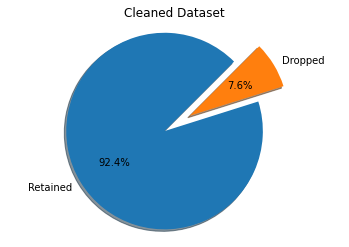

In [36]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Retained', 'Dropped'
sizes = [df.shape[0], df_raw.shape[0] - df.shape[0]]
explode = (0, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Cleaned Dataset')
plt.show()

## 4. Train/Test Split

In [37]:
# Train/Test Split
features = [col for col in df._get_numeric_data().columns if col != 'weekly_sales']
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
# # Scale features with standardisation

# # Initialise StandardScaler
# ss = StandardScaler()

# # standardise training set
# X_train_ss = ss.fit_transform(X_train)
# X_train_ss = pd.DataFrame(X_train_ss, columns=X.columns)
# display(X_train_ss.describe())

# # standardise training set
# X_test_ss = ss.fit_transform(X_test)
# X_test_ss = pd.DataFrame(X_test_ss, columns=X.columns)
# X_test_ss.describe()

In [39]:
df

,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,size,weekday,have_promotion,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17,store_18,store_19,store_20,store_21,store_22,store_23,store_24,store_25,store_26,store_27,store_28,store_29,store_30,store_31,store_32,store_33,store_34,store_35,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,dept_11,dept_12,dept_13,dept_14,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,dept_22,dept_23,dept_24,dept_25,dept_26,dept_27,dept_28,dept_29,dept_30,dept_31,dept_32,dept_33,dept_34,dept_35,dept_36,dept_37,dept_38,dept_39,dept_40,dept_41,dept_42,dept_43,dept_44,dept_45,dept_46,dept_47,dept_48,dept_49,dept_50,dept_51,dept_52,dept_54,dept_55,dept_56,dept_58,dept_59,dept_60,dept_65,dept_67,dept_71,dept_72,dept_74,dept_77,dept_78,dept_79,dept_80,dept_81,dept_82,dept_83,dept_85,dept_87,dept_90,dept_91,dept_92,dept_93,dept_94,dept_95,dept_96,dept_97,dept_98,dept_99,type_B,type_C,year_2011,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389382,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## 5. Modelling

### Model Summary

**Model Evaluation**

|Model Type|Test R2 Score|MAE|MSE|
|:--|:-:|:-:|:-:|
|Linear Regression|0.6663|8153.43|13124.01|
|Ridge Regression|0.6663|8148.71|13123.85|
|Lasso Regression|0.6638|8112.69|13172.38|
|Elastic Net Regression|0.0920|14301.93|21648.48|
|**Decision Tree**|**0.9079**|**2233.29**|**6896.41**|

\
**Decision Tree best results so we refine the input data and use Random Forest, an advanced model of DTs**

**Model Evaluation post Transformed Data**

|Model Type|Test R2 Score|MAE|MSE|
|:--|:--|:-:|:-:|
|Decision Tree|0.9290|2079.23|6001.41|
|**Random Forest**|**0.9505**|**1603.51**|**5027.13**|

In [40]:
# Scaling only numeric features using sklearn StandardScalar
numeric=['temperature', 'fuel_price', 'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5',
        'cpi', 'unemployment', 'size']
ss=StandardScaler()
X_train[numeric]=ss.fit_transform(X_train[numeric])
X_test[numeric]=ss.transform(X_test[numeric])

C:\Users\assau\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\assau\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [41]:
# Create a LinearRegression object
lr= LinearRegression()
# Fit X and y 
lr.fit(X_train, y_train)
ypred = lr.predict(X_test)
# Metrics to evaluate your model 
r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred))

(0.6662926486394253, 8153.428176728609, 13124.01256754475)

In [42]:
# Test out 100 different evenly spaced alpha values between 0.1 and 10 on default 5-folds of data set and adopt the best performing alpha
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

ridge.fit(X_train, y_train)
yrid = ridge.predict(X_test)

r2_score(y_test, yrid), mean_absolute_error(y_test, yrid), np.sqrt(mean_squared_error(y_test, yrid))

(0.666300933495019, 8148.714827113014, 13123.84965350742)

In [43]:
# Testing out 200 different alpha values on default 5-folds of data set and adopt the best performing alpha
lasso = LassoCV(n_alphas=200)

# Lasso R2 on train & test
lasso.fit(X_train, y_train)
ylas = lasso.predict(X_test)

r2_score(y_test, ylas), mean_absolute_error(y_test, ylas), np.sqrt(mean_squared_error(y_test, ylas))

(0.6638283748232376, 8112.685988291298, 13172.38080655388)

In [44]:
# Elastic Net Regression model
elas = ElasticNet().fit(X_train,y_train)
yelas = elas.predict(X_test)

r2_score(y_test, yelas), mean_absolute_error(y_test, yelas), np.sqrt(mean_squared_error(y_test, yelas))

(0.09199689212324902, 14301.931509525068, 21648.48046693107)

In [45]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat = dt.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.9078536726096704, 2233.288326604826, 6896.405124117528)

### Model Comparisons

Recall: variables cpi and size are skewed, hence we apply a transformer to normalise behaviour

In [46]:
df

,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,size,weekday,have_promotion,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17,store_18,store_19,store_20,store_21,store_22,store_23,store_24,store_25,store_26,store_27,store_28,store_29,store_30,store_31,store_32,store_33,store_34,store_35,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,dept_11,dept_12,dept_13,dept_14,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,dept_22,dept_23,dept_24,dept_25,dept_26,dept_27,dept_28,dept_29,dept_30,dept_31,dept_32,dept_33,dept_34,dept_35,dept_36,dept_37,dept_38,dept_39,dept_40,dept_41,dept_42,dept_43,dept_44,dept_45,dept_46,dept_47,dept_48,dept_49,dept_50,dept_51,dept_52,dept_54,dept_55,dept_56,dept_58,dept_59,dept_60,dept_65,dept_67,dept_71,dept_72,dept_74,dept_77,dept_78,dept_79,dept_80,dept_81,dept_82,dept_83,dept_85,dept_87,dept_90,dept_91,dept_92,dept_93,dept_94,dept_95,dept_96,dept_97,dept_98,dept_99,type_B,type_C,year_2011,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,151315,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389382,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [47]:
# Train/Test Split
features = [col for col in df._get_numeric_data().columns if col != 'weekly_sales']
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)
round(r2_score(y_test, yhat), 3), round(mean_absolute_error(y_test, yhat), 2), round(np.sqrt(mean_squared_error(y_test, yhat)),2)

(0.929, 2079.23, 6001.41)

In [48]:
model = RandomForestRegressor()
# transforming target variable through quantile transformer
ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)
yhat = ttr.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.9505120254961819, 1603.5067678099024, 5027.125572433481)